In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print('training data {}'.format(train.shape))
print('test data {}'.format(test.shape))

training data (7613, 5)
test data (3263, 4)


In [6]:
# target class distribution
target_count=train.target.value_counts()
target_count

0    4342
1    3271
Name: target, dtype: int64

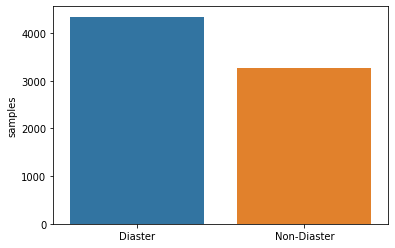

In [7]:
# sns.barplot(target_count.index, target_count)
sns.barplot(['Diaster', 'Non-Diaster'], target_count)
plt.gca().set_ylabel('samples')
plt.show()

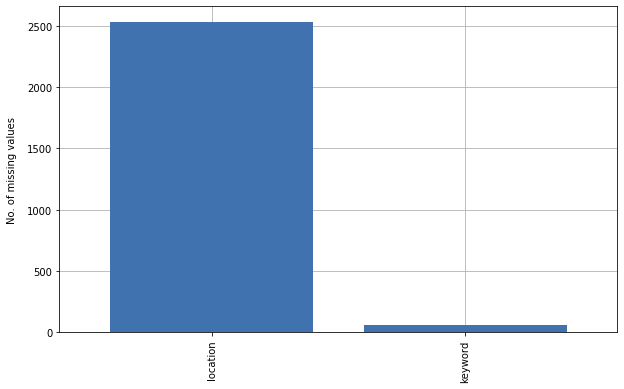

In [8]:
# plot missing values
nans = train.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [9]:
# combine train and test data so that we dont need to process them separately
# although this may result in data leak but for simplicity
df = pd.concat([train.drop("target", axis=1), test])
print('train shape = {}'.format(train.shape))
print('test shape = {}'.format(test.shape))
print('combined data shape = {}'.format(df.shape))

train shape = (7613, 5)
test shape = (3263, 4)
combined data shape = (10876, 4)


**Create new features**


In [0]:
import re
def search_links(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url 

In [11]:
df['link_available']=df['text'].apply(lambda x: 1 if len(search_links(x)) > 0 else 0)
df.tail()

,id,keyword,location,text,link_available
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,0


In [12]:
df['word_count']=df['text'].apply(lambda x: len(x.split()))
df.head()

,id,keyword,location,text,link_available,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,0,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,0,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,0,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",0,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,0,16


**Data Cleaning**

In [0]:
import nltk
nltk.download('popular')

In [14]:
# Tokenization
from nltk.tokenize import word_tokenize
text = "After sleeping for four hours, he decided to sleep for another four"
tokens = word_tokenize(text)
print(tokens)

['After', 'sleeping', 'for', 'four', 'hours', ',', 'he', 'decided', 'to', 'sleep', 'for', 'another', 'four']


In [15]:
# remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
  word_tokens = word_tokenize(sentence)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  return " ".join(filtered_sentence)

print(remove_stop_words("This is a sample sentence, showing off the stop words filtration."))
# df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

This sample sentence , showing stop words filtration .


In [16]:
!pip install autocorrect

     |████████████████████████████████| 19.1MB 201kB/s 
  Created wheel for autocorrect: filename=autocorrect-0.4.4-cp36-none-any.whl size=19134813 sha256=c565da8a1cceaafd802ce132f54b638e7bf08aa45bd27d854f5c22f12a26cdab
  Stored in directory: /root/.cache/pip/wheels/e5/80/6d/feed99c22f3f15b0b6881569dc9021f7e94b6464aa0688d819
Successfully built autocorrect


In [17]:
# Spelling correction
from autocorrect import Speller
spell = Speller(lang='en')
def correct_spellings(sentence):
  return spell(sentence)
print(spell('caaaar mussage loev maintanance survice hte'))

caesar message love maintenance service the


In [18]:
# Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()
print(ps.stem("python"))
print(ps.stem("pythoner"))
print(ps.stem("pythoning"))
print(ps.stem("pythoned"))

def stemming(sentence):
  # ps = PorterStemmer()
  token_words=word_tokenize(sentence)
  token_words
  stem_sentence=[]
  for word in token_words:
    stem_sentence.append(ps.stem(word))
  return " ".join(stem_sentence)

print(stemming("python pythoner pythoning pythoned"))

python
python
python
python
python python python python


In [19]:
# Lemmatization Text lemmatization is the process of eliminating redundant prefix or suffix of a word and extract the base word (lemma).
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print("cats :", lemmatizer.lemmatize("cats"))
print("rocks :", lemmatizer.lemmatize("rocks")) 
print("corpora :", lemmatizer.lemmatize("corpora")) 
# a denotes adjective in "pos" 
print("better :", lemmatizer.lemmatize("better", pos ="a")) 

def lemmatization(sentence):
    # lemmatizer = WordNetLemmatizer()
    token_words=word_tokenize(sentence)
    token_words
    lem_sentence=[]
    for word in token_words:
        lem_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(lem_sentence)

print(lemmatization("cats cars corpora"))


cats : cat
rocks : rock
corpora : corpus
better : good
cat car corpus


In [20]:
# removing links
import re
def remove_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_links("This is the url of google  :https://www.google.com")

'This is the url of google  :'

In [21]:
# removing html from text
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
    
print(remove_html("""<div>
<h1>Competition</h1>
<p>Data Science</p>
<a href="https://www.kaggle.com/">Kaggle link</a>
</div>"""))


Competition
Data Science
Kaggle link



In [22]:
# removeing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Aweeee 😔😔")

'Aweeee '

In [23]:
# removing punctuation
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

print(remove_punct("I am a #king"))

I am a king


In [0]:
def clean_data(sentence):
  sentence = remove_links(sentence)
  sentence = remove_stop_words(sentence)
  sentence = remove_punct(sentence)
  sentence = remove_html(sentence)
  sentence = remove_emoji(sentence)
  sentence = lemmatization(sentence)
  sentence = stemming(sentence)
  sentence = correct_spellings(sentence)
  print(sentence)
  return sentence.lower()

In [0]:
# clean text column
df['text'].replace("[^a-zA-Z]"," ",regex=True, inplace=True)
df['text']=df['text'].apply(lambda sentence : clean_data(sentence))

In [0]:
df.to_csv('cleaned_combined.csv') 

In [27]:
df.head(10)

,id,keyword,location,text,link_available,word_count
0,1,NaN,NaN,our deed reason earthquake may allah forgive u,0,13
1,4,NaN,NaN,forest fire near la rong ask canada,0,7
2,5,NaN,NaN,all resid ask shelter place notify offic no ev...,0,22
3,6,NaN,NaN,people receive wildfire evacue order california,0,8
4,7,NaN,NaN,just got sent photo ruby alaska smoke wildfire...,0,16
5,8,NaN,NaN,rockhair upeat california twi close direct due...,0,18
6,10,NaN,NaN,flood dikast heavy rain caus flash flood stree...,0,14
7,13,NaN,NaN,i top hill i see fire wood,0,15
8,14,NaN,NaN,there emerge evacue happen build across street,0,12
9,15,NaN,NaN,i afraid tornado come area,0,10


In [0]:
# df=df.drop(['id','keyword','location'], axis=1)
df = df['text']
x_train=df[:train.shape[0]]
x_test=df[train.shape[0]:]
y_train=train['target']

In [29]:
df.head()

0       our deed reason earthquake may allah forgive u
1                  forest fire near la rong ask canada
2    all resid ask shelter place notify offic no ev...
3      people receive wildfire evacue order california
4    just got sent photo ruby alaska smoke wildfire...
Name: text, dtype: object

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
## implement BAG OF WORDS
countvector=CountVectorizer(ngram_range=(2,2))
x_train=countvector.fit_transform(x_train).toarray()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV 
import numpy as np

In [0]:
# grid={"C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"], "solver":['liblinear', 'saga']}
# log_reg = LogisticRegression(max_iter=2000, random_state=20)
# # scoring=['roc_auc', 'f1']
# random_search = RandomizedSearchCV(log_reg, grid, refit = True, verbose = 3, cv=5, n_jobs=-1, scoring = 'f1') 
random_search = LogisticRegression()

In [35]:
random_search.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# random_search.best_score_

In [37]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

x_valid = countvector.transform(x_valid).toarray()
predictions_validation = random_search.predict(x_valid)

matrix=confusion_matrix(y_valid,predictions_validation)
print(matrix)
score=accuracy_score(y_valid,predictions_validation)
print(score)
report=classification_report(y_valid,predictions_validation)
print(report)

[[991 100]
 [408 405]]
0.7331932773109243
              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1091
           1       0.80      0.50      0.61       813

    accuracy                           0.73      1904
   macro avg       0.76      0.70      0.71      1904
weighted avg       0.75      0.73      0.72      1904



In [38]:
predictions_train = random_search.predict(x_train)
accuracy_score(y_train,predictions_train)

0.9880889823086355

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.79


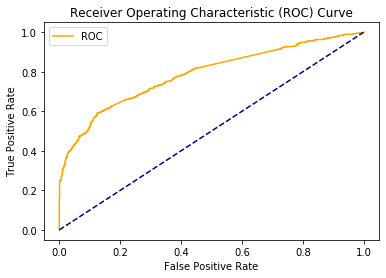

In [41]:
probs = random_search.predict_proba(x_valid)
probs = probs[:, 1]

auc = roc_auc_score(y_valid, probs)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(y_valid, probs)

plot_roc_curve(fpr, tpr)

In [42]:
x_test = countvector.transform(x_test).toarray()
predictions = random_search.predict(x_test)
submission = pd.DataFrame({
        "id": test['id'],
        "target": predictions
    })
submission.to_csv('submission.csv', index=False)
print('Exported')

Exported


In [0]:
# import xgboost as xgb

In [0]:
# xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(x_train, y_train)
# predictions_validation = xg_reg.predict(x_valid)
# accuracy_score(y_valid,predictions_validation)